In [20]:
%matplotlib inline
import os, struct
from array import array as pyarray
import numpy as np
from scipy.cluster.vq import *
from numpy import append, array, int8, uint8, zeros
from pylab import *
from numpy import *

In [21]:
def load_mnist(dataset="training", digits=np.arange(10), path="."):
    """
    Loads MNIST files into 3D numpy arrays

    Adapted from: http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py
    """

    if dataset == "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset == "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = pyarray("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = pyarray("B", fimg.read())
    fimg.close()

    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = len(ind)

    images = zeros((N, rows, cols), dtype=uint8)
    labels = zeros((N, 1), dtype=int8)
    for i in range(len(ind)):
        images[i] = array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ]).reshape((rows, cols))
        labels[i] = lbl[ind[i]]

    return images, labels

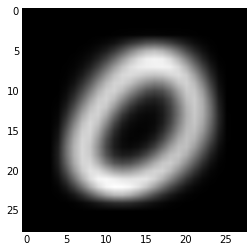

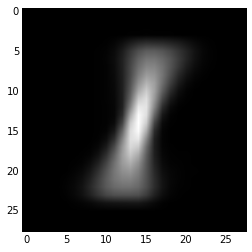

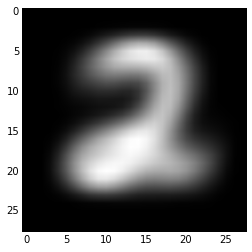

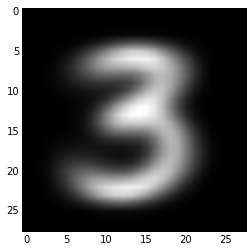

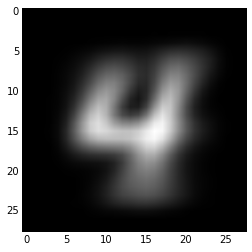

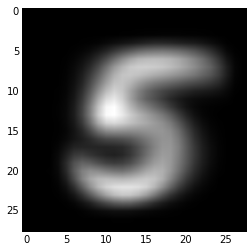

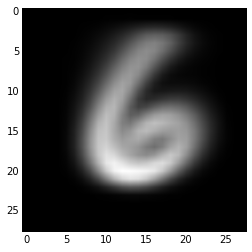

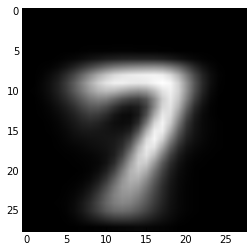

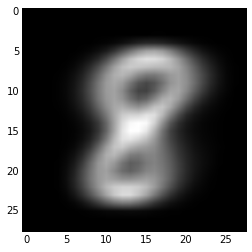

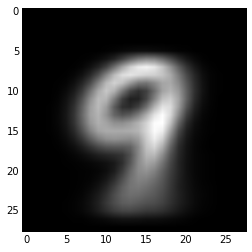

In [24]:
images0, label = load_mnist('training', digits=[0])
images1, label = load_mnist('training', digits=[1])
images2, label = load_mnist('training', digits=[2])
images3, label = load_mnist('training', digits=[3])
images4, label = load_mnist('training', digits=[4])
images5, label = load_mnist('training', digits=[5])
images6, label = load_mnist('training', digits=[6])
images7, label = load_mnist('training', digits=[7])
images8, label = load_mnist('training', digits=[8])
images9, label = load_mnist('training', digits=[9])

imshow(images0.mean(axis=0), cmap=cm.gray)
show()
imshow(images1.mean(axis=0), cmap=cm.gray)
show()
imshow(images2.mean(axis=0), cmap=cm.gray)
show()
imshow(images3.mean(axis=0), cmap=cm.gray)
show()
imshow(images4.mean(axis=0), cmap=cm.gray)
show()
imshow(images5.mean(axis=0), cmap=cm.gray)
show()
imshow(images6.mean(axis=0), cmap=cm.gray)
show()
imshow(images7.mean(axis=0), cmap=cm.gray)
show()
imshow(images8.mean(axis=0), cmap=cm.gray)
show()
imshow(images9.mean(axis=0), cmap=cm.gray)
show()

    